数据集下载地址：https://www.kesci.com/home/dataset/5bfe734a954d6e0010683839/project

# [鬼斧神工]基于TibetanMNIST数据集的图像分类与图像匹配

## 主要内容
- 基于TibetanMNIST数据集进行图像分类实验 

  >  LogisticRegression、多层MLP、卷积神经网络
   
- 基于TibetanMNIST数据集进行图像相似判定实验

  > 孪生网络Siamese Network

## 加载数据

In [151]:
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

# 参数设置
batch_size=128
n_classes=10
n_epochs=20

# img_rows=28
# img_cols=28

# 加载数据
data = np.load('not_upload/TibetanMNIST.npz')
X, y = data['image'], data['label']  # (17768, 28, 28)
X = X.reshape(17768, 784).astype('float32') / 255
y = np_utils.to_categorical(y, num_classes=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 函数定义

In [152]:
import matplotlib.pyplot as plt
def draw_train(history):
    '''
    绘制训练曲线
    :param history:
    :return:
    '''

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def draw_img(X):
    """
    画图像
    :return:
    """
    plt.imshow(X, cmap='gray')
    plt.show()


## 基于TibetanMNIST数据集进行图像分类实验

### 1 逻辑回归

In [153]:
from keras.models import  Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

model=Sequential()
model.add(Dense(input_shape=(784,),units=10,activation='softmax'))
model.compile(optimizer=RMSprop(lr=0.001,rho=0.9),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
history=model.fit(X_train,y_train,
                  batch_size=batch_size,
                  epochs=n_epochs,
                  verbose=1,
                  validation_data=(X_test,y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 13326 samples, validate on 4442 samples
Epoch 1/20
13326/13326 [==============================] - 1s 41us/step - loss: 0.1447 - acc: 0.9459 - val_loss: 0.0840 - val_acc: 0.9714
Epoch 2/20
13326/13326 [==============================] - 0s 20us/step - loss: 0.0732 - acc: 0.9751 - val_loss: 0.0651 - val_acc: 0.9771
Epoch 3/20
13326/13326 [==============================] - 0s 20us/step - loss: 0.0606 - acc: 0.9792 - val_loss: 0.0574 - val_acc: 0.9807
Epoch 4/20
13326/13326 [==============================] - 0s 20us/step - loss: 0.0544 - acc: 0.9813 - val_loss: 0.0545 - val_acc: 0.9817
Epoch 5/20
13326/13326 [==============================] - 0s 20us/step 

4442/4442 [==============================] - 0s 36us/step
Summary: Loss over the test dataset: 0.0425, Accuracy: 0.9860


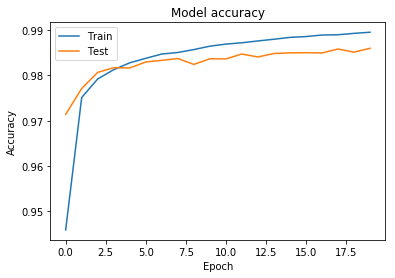

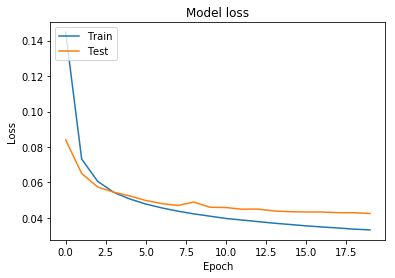

In [154]:
evaluation=model.evaluate(X_test,y_test)
print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))
draw_train(history)

### 2 多层MLP

In [155]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(input_shape=(784,), units=512, activation='relu',name="Dense1"))
model.add(Dropout(0.2,name='Dropout1'))
model.add(Dense(input_shape=(512,), units=256, activation='relu',name='Dense2'))
model.add(Dropout(0.2,name='Dropout2'))
model.add(Dense(input_shape=(256,), units=10, activation='softmax',name='Dense3'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history=model.fit(x=X_train, y=y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 512)               401920    
_________________________________________________________________
Dropout1 (Dropout)           (None, 512)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
Dropout2 (Dropout)           (None, 256)               0         
_________________________________________________________________
Dense3 (Dense)               (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
Train on 13326 samples, validate on 4442 samples
Epoch 1/20
13326/13326 [==============================] - 1s 74us/step - loss: 0.0822 -

4442/4442 [==============================] - 0s 34us/step
Summary: Loss over the test dataset: 0.0281, Accuracy: 0.9929


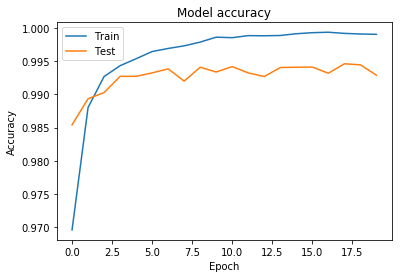

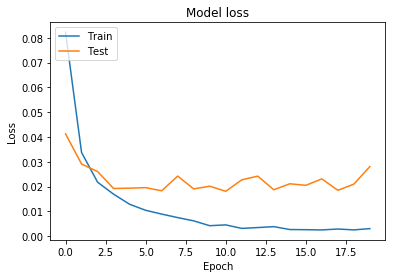

In [156]:
evaluation = model.evaluate(X_test, y_test, verbose=1)
print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))
draw_train(history)

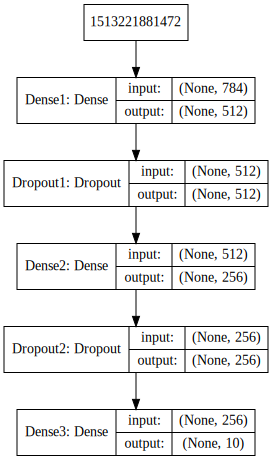

In [157]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

### 3 CNN 卷积神经网络

在这里我们尝试下经典的卷积神经网络，用于图像分类，需要注意的是我们这里加载的数据方式（y_test_）与前面有所区别（为了后面的验证）

In [205]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
import keras.backend as K
import matplotlib.pyplot as plt
# 参数设置
batch_size=128
n_classes=10
n_epochs=20


# 加载数据
data = np.load('not_upload/TibetanMNIST.npz')
X, y = data['image'], data['label']  # (17768, 28, 28)
X = X.reshape(X.shape[0], 28,28,1).astype('float32') / 255
X_train, X_test, y_train, y_test_ = train_test_split(X, y, random_state=42)
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_test = np_utils.to_categorical(y_test_, num_classes=10)

In [206]:
# 构建模型
input_shape=(28,28,1)
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
__________

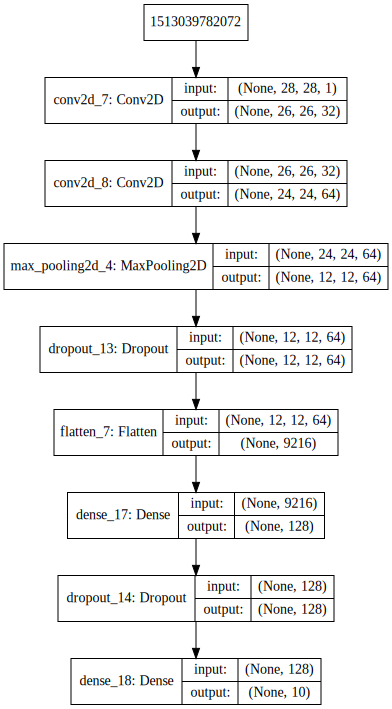

In [209]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

4442/4442 [==============================] - 0s 87us/step
Summary: Loss over the test dataset: 0.0886, Accuracy: 0.9766


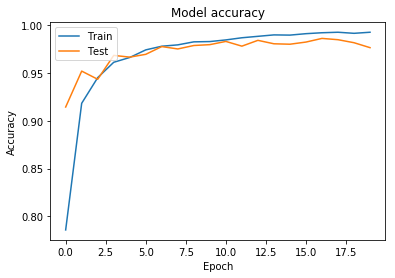

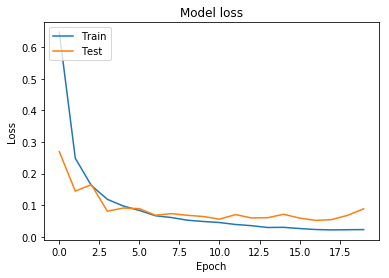

In [210]:
evaluation = model.evaluate(X_test, y_test, verbose=1)
print('Summary: Loss over the test dataset: %.4f, Accuracy: %.4f' % (evaluation[0], evaluation[1]))
draw_train(history)

**展示下预测的正确标签与错误标签**

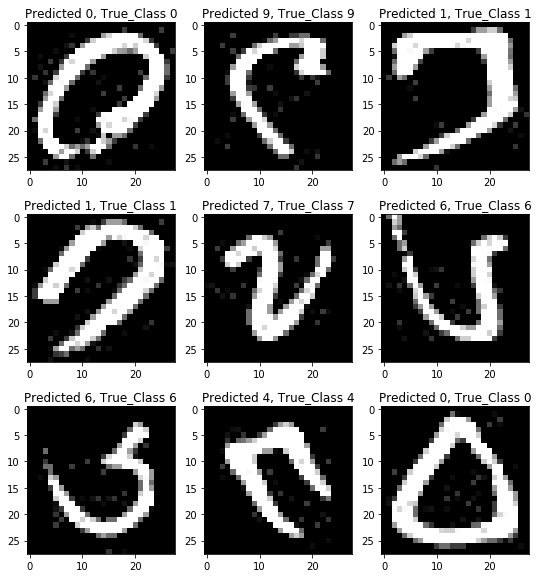

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0 9 1 ... 2 5 1]


In [211]:
predicted_classes = model.predict_classes(X_test)
correct_indices = np.nonzero(predicted_classes == y_test_)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test_)[0]

plt.figure(figsize=(9,10))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, True_Class {}".format(predicted_classes[correct], y_test_[correct]))
plt.show()
print(type(predicted_classes))
print(type(y_test_))
print(predicted_classes)

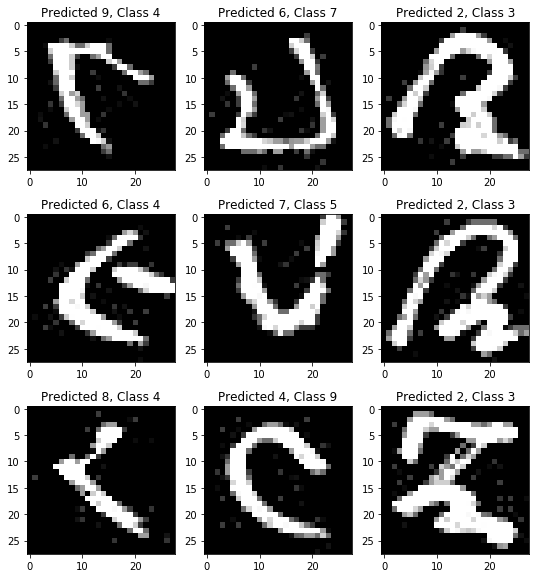

array([0, 9, 1, ..., 3, 5, 1])

In [176]:
plt.figure(figsize=(9,10))
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[incorrect].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test_[incorrect]))
plt.show()

## 基于TibetanMNIST数据集进行图像相似判定实验

![](https://upload-images.jianshu.io/upload_images/10313103-32ad7ac7475506b6.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/600/format/webp)

In [212]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.utils import np_utils
from keras.layers import Dense, Input, Flatten
from keras.layers import Dropout, Activation, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import keras.backend as K

## 准备数据

这一部分主要目的：准备image pair；准备正负样本

In [213]:
# 准备数据
data = np.load('not_upload/TibetanMNIST.npz')
X, y = data['image'], data['label']  # (17768, 28, 28)
X = X.astype('float32') / 255
# y = np_utils.to_categorical(y, num_classes=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [214]:
# 创建正负样本 比如 x为[img_0,img_0],那么label为1，x为[img_0,img_1],label为0
def create_pairs(x, digit_indices, num_classes):
    pairs = []
    labels = []
    n = min([len(digit_indices[j]) for j in range(num_classes)]) - 1
    for j in range(num_classes):
        for i in range(n):
            p1, p2 = digit_indices[j][i], digit_indices[j][i + 1]
            pairs += [[x[p1], x[p2]]]
            inc = random.randrange(1, num_classes)
            jn = (j + inc) % num_classes
            p1, p2 = digit_indices[j][i], digit_indices[jn][i]
            pairs += [[x[p1], x[p2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [215]:
num_classes = len(np.unique(y_train))
# 训练集
digit_indices = [np.where(y_train == i)[0] for i in range(0, 10)]
train_pairs, train_y = create_pairs(X_train, digit_indices, num_classes)
# 测试集
digit_indices = [np.where(y_test == i)[0] for i in range(0, 10)]
test_pairs, test_y = create_pairs(X_test, digit_indices, num_classes)

## 函数定义

In [216]:
# 损失函数
def contrastive_loss(y_true, y_pred):
    margin = 1
    sq_pred = K.square(y_pred)
    margin_sq = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y_true * sq_pred + (1 - y_true) * margin_sq)
    return loss

In [217]:
# 欧式距离
def euclidean_distance(vects):
    x, y = vects
    sum_sq = K.sum(K.square(x - y), axis=1, keepdims=True)
    distance = K.sqrt(K.maximum(sum_sq, K.epsilon()))
    return distance

def eucl_shape(shape):
    shape1, shape2 = shape
    return (shape1[0], 1)

## 创建Siamese Network

In [218]:
# 创建Siamese模型
def shared_network(input_shape):
    """
    共享层
    :param input_shape:
    :return:
    """
    input = Input(shape=input_shape)
    layer = Flatten()(input)
    layer = Dense(128, activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(128, activation='relu')(layer)
    return Model(input, layer)

In [219]:
input_shape = X_train.shape[1:]
siamese = shared_network(input_shape)
input_left = Input(shape=input_shape)
input_right = Input(shape=input_shape)
output_left = siamese(input_left)
output_right = siamese(input_right)


In [220]:
distance = Lambda(euclidean_distance,
                  output_shape=eucl_shape)([output_left, output_right])
model = Model([input_left, input_right], distance)
ada = Adadelta()

需要注意的是我们模型最后的输出是distance，即欧式距离，而不是概率，所以我们需要重新定义acc，即如果两张图片距离小于0.5，那么为我们认为两张图片相似或者一样

In [196]:
threshold = 0.5
def acc(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < threshold, y_true.dtype)))

In [197]:
model.compile(loss=contrastive_loss, optimizer=ada, metrics=[acc])
filepath = "model/model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [198]:
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
                    batch_size=128,
                    epochs=20,
                    callbacks=[checkpoint],
                    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y))

Train on 19720 samples, validate on 6280 samples
Epoch 1/20
19720/19720 [==============================] - 1s 65us/step - loss: 0.1878 - acc: 0.7388 - val_loss: 0.1097 - val_acc: 0.8615

Epoch 00001: val_acc improved from -inf to 0.86146, saving model to model/model.hdf5
Epoch 2/20
19720/19720 [==============================] - 1s 36us/step - loss: 0.1082 - acc: 0.8720 - val_loss: 0.0813 - val_acc: 0.9078

Epoch 00002: val_acc improved from 0.86146 to 0.90780, saving model to model/model.hdf5
Epoch 3/20
19720/19720 [==============================] - 1s 36us/step - loss: 0.0816 - acc: 0.9130 - val_loss: 0.0666 - val_acc: 0.9263

Epoch 00003: val_acc improved from 0.90780 to 0.92627, saving model to model/model.hdf5
Epoch 4/20
19720/19720 [==============================] - 1s 36us/step - loss: 0.0647 - acc: 0.9381 - val_loss: 0.0573 - val_acc: 0.9396

Epoch 00004: val_acc improved from 0.92627 to 0.93965, saving model to model/model.hdf5
Epoch 5/20
19720/19720 [==========================

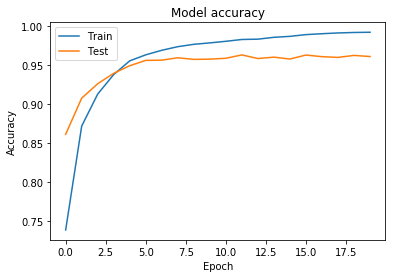

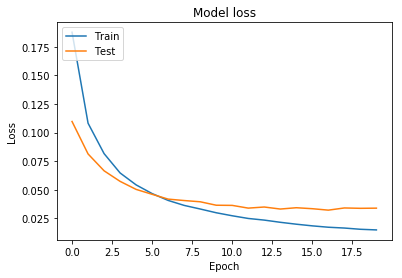

In [199]:
draw_train(history)

## 模型评估
我们看下在训练集和测试集上面的准确率

In [221]:
# 评估模型
# 加载模型 best for test
model.load_weights("model/model.hdf5")
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < threshold
    return np.mean(pred == y_true)


y_pred = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
train_acc = compute_accuracy(train_y, y_pred)
y_pred = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_acc = compute_accuracy(test_y, y_pred)
print('Accuracy on training set: %.4f' % train_acc)
print('Accuracy on test set: %.4f' % test_acc)

Accuracy on training set: 0.9859
Accuracy on test set: 0.9613


**预测两张图片是否相似的正确情况**

Group:1,Predicted 1, Label 1


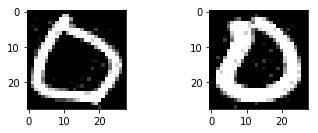

Group:2,Predicted 0, Label 0


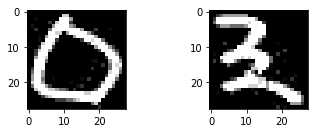

Group:3,Predicted 1, Label 1


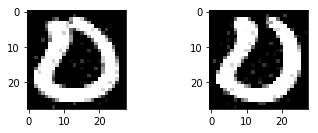

Group:4,Predicted 0, Label 0


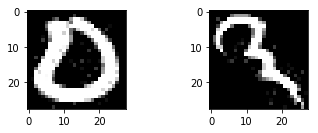

In [227]:
pred = y_pred.ravel() < threshold
pred=pred+0
correct_indices = np.nonzero(pred==test_y)[0]
incorrect_indices = np.nonzero(pred!=test_y)[0]

for i, correct in enumerate(correct_indices[:4]):
    print("Group:{},Predicted {}, Label {}".format(i+1,pred[correct], test_y[correct]))
    plt.figure()
    plt.subplot(221)
    plt.imshow(train_pairs[:, 0][correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.subplot(222)
    plt.imshow(train_pairs[:, 1][correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.show()


**预测两张图片是否相似的错误情况**

Group:1,Predicted 0, Label 1


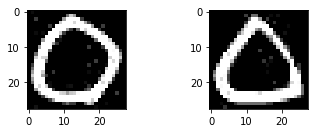

Group:2,Predicted 0, Label 1


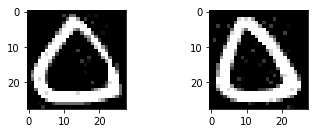

Group:3,Predicted 1, Label 0


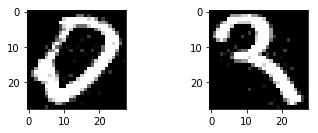

Group:4,Predicted 0, Label 1


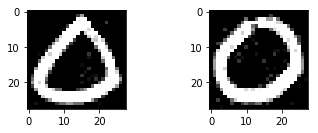

In [230]:
for i, correct in enumerate(incorrect_indices[:4]):
    print("Group:{},Predicted {}, Label {}".format(i+1,pred[correct], test_y[correct]))
    plt.figure()
    plt.subplot(221)
    plt.imshow(train_pairs[:, 0][correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.subplot(222)
    plt.imshow(train_pairs[:, 1][correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.show()
